## Star Predicting on yelp Dataset

In [64]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [65]:
import tensorflow as tf
print("Tensor Flow Version: {}".format(tf.__version__))

Tensor Flow Version: 1.11.0


## Reading json files

In [66]:
import json
import csv
import pandas as pd

outfile = open("review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'text'])
with open(r'yelp_academic_dataset_review.json',encoding="utf-8") as f:
  for line in f:
     row = json.loads(line)
# some special char must be encoded in 'utf-8'
     sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])
outfile.close()
reviews_df= pd.read_csv('review_stars.tsv', delimiter ="\t", encoding="utf-8")


In [67]:
import json
import csv
import pandas as pd

outfile = open("business_reviews.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'review_count'])
with open(r'yelp_academic_dataset_business.json',encoding ="utf-8") as f:
  for line in f:
     row = json.loads(line)
# some special char must be encoded in 'utf-8'
     sfile.writerow([row['business_id'], row['stars'], (row['review_count'])])
outfile.close()
business_df= pd.read_csv('business_reviews.tsv', delimiter ="\t", encoding="utf-8")

In [68]:
reviews_df.isnull().sum()
business_df.isnull().sum()


business_id     0
stars           0
review_count    0
dtype: int64

In [69]:
review_df_agg=reviews_df.groupby('business_id')['text'].sum()

In [70]:
review_df_for_sklearn=pd.DataFrame({'business_id':review_df_agg.index,'all_reviews':review_df_agg.values})

In [71]:
review_business=pd.merge(review_df_for_sklearn,business_df,on='business_id',how='left')

In [72]:
review_business.shape

(188593, 4)

In [73]:
review_business_sample=review_business.sample(frac=.10)
print(review_business_sample.shape)

(18859, 4)


In [74]:
#normalizing review_count

from scipy.stats import zscore

review_count_normalized=zscore(review_business_sample['review_count'])
review_count_normalized.shape #normalized review_count

(18859,)

## TF-IDF

In [75]:
import sklearn.feature_extraction.text as sk_text
vectorizer=sk_text.TfidfVectorizer(stop_words='english',max_features=1000,min_df=2)
matrix=vectorizer.fit_transform(review_business_sample['all_reviews'])


In [76]:
print(type(matrix))
print(matrix.toarray())

<class 'scipy.sparse.csr.csr_matrix'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.02241741 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.07193545 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [77]:
tfif_data=matrix.toarray()

In [78]:
tfif_data.shape


(18859, 1000)

In [79]:
import numpy as np
concat_matrix=np.column_stack((tfif_data,review_count_normalized))
concat_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.24019547],
       [ 0.        ,  0.        ,  0.02241741, ...,  0.        ,
         0.        , -0.20975322],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.2604903 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.28078512],
       [ 0.        ,  0.07193545,  0.        , ...,  0.        ,
         0.        , -0.21990064],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.29093254]])

# TensorFlow Regression

In [80]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

x=concat_matrix

le = preprocessing.LabelEncoder()
le.fit(review_business_sample['stars'])

list(le.classes_)

y = le.transform(review_business_sample['stars'])

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics

model = Sequential()

model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1     #  why input_dim=x.shape[1]?  
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(x,y,verbose=2,epochs=100)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

pred = model.predict(x)
print("Shape: {}".format(pred.shape))
print(pred)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y))
print("Final score (RMSE): {}".format(score))

In [196]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics

model = Sequential()

model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1     #  why input_dim=x.shape[1]?  
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(x,y,verbose=2,epochs=100)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

pred = model.predict(x)
print("Shape: {}".format(pred.shape))
print(pred)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y))
print("Final score (RMSE): {}".format(score))

Epoch 1/100
 - 7s - loss: 5.6814
Epoch 2/100
 - 2s - loss: 1.1893
Epoch 3/100
 - 2s - loss: 1.0341
Epoch 4/100
 - 3s - loss: 0.9214
Epoch 5/100
 - 3s - loss: 0.8462
Epoch 6/100
 - 3s - loss: 0.7972
Epoch 7/100
 - 2s - loss: 0.7547
Epoch 8/100
 - 2s - loss: 0.7171
Epoch 9/100
 - 2s - loss: 0.6819
Epoch 10/100
 - 2s - loss: 0.6449
Epoch 11/100
 - 3s - loss: 0.6169
Epoch 12/100
 - 2s - loss: 0.5867
Epoch 13/100
 - 2s - loss: 0.5544
Epoch 14/100
 - 2s - loss: 0.5290
Epoch 15/100
 - 3s - loss: 0.5036
Epoch 16/100
 - 3s - loss: 0.4824
Epoch 17/100
 - 2s - loss: 0.4613
Epoch 18/100
 - 2s - loss: 0.4418
Epoch 19/100
 - 2s - loss: 0.4256
Epoch 20/100
 - 2s - loss: 0.4094
Epoch 21/100
 - 2s - loss: 0.3973
Epoch 22/100
 - 2s - loss: 0.3828
Epoch 23/100
 - 2s - loss: 0.3720
Epoch 24/100
 - 2s - loss: 0.3590
Epoch 25/100
 - 2s - loss: 0.3512
Epoch 26/100
 - 2s - loss: 0.3445
Epoch 27/100
 - 3s - loss: 0.3333
Epoch 28/100
 - 3s - loss: 0.3278
Epoch 29/100
 - 3s - loss: 0.3206
Epoch 30/100
 - 2s - lo

In [87]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="/Users/avinashreddy/Desktop/215/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1)) # Output

    model.compile(loss='mean_squared_error', optimizer='rmsprop')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)


print('Training finished...Loading the best model')  
print()
model.load_weights("/Users/avinashreddy/Desktop/215/best_weights.hdf5",) # load weights from best model

# Predict
pred = model.predict(x_test)

# Measure MSE error.  
score = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(score))

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))


0
Train on 14144 samples, validate on 4715 samples
Epoch 1/100
 - 4s - loss: 2.3478 - val_loss: 1.1540
Epoch 2/100
 - 2s - loss: 1.0210 - val_loss: 0.9898
Epoch 3/100
 - 2s - loss: 0.8735 - val_loss: 1.1188
Epoch 4/100
 - 2s - loss: 0.7809 - val_loss: 0.9863
Epoch 5/100
 - 2s - loss: 0.6807 - val_loss: 0.9483
Epoch 6/100
 - 2s - loss: 0.5863 - val_loss: 1.0578
Epoch 7/100
 - 2s - loss: 0.4869 - val_loss: 1.0111
Epoch 8/100
 - 2s - loss: 0.4090 - val_loss: 1.0511
Epoch 9/100
 - 2s - loss: 0.3477 - val_loss: 1.0459
Epoch 10/100
 - 2s - loss: 0.2911 - val_loss: 1.0675
Epoch 00010: early stopping
1
Train on 14144 samples, validate on 4715 samples
Epoch 1/100
 - 4s - loss: 2.2665 - val_loss: 1.1039
Epoch 2/100
 - 2s - loss: 1.0430 - val_loss: 1.1558
Epoch 3/100
 - 2s - loss: 0.8938 - val_loss: 0.9514
Epoch 4/100
 - 2s - loss: 0.7900 - val_loss: 1.0254
Epoch 5/100
 - 2s - loss: 0.6963 - val_loss: 0.9518
Epoch 6/100
 - 2s - loss: 0.5975 - val_loss: 1.1260
Epoch 7/100
 - 2s - loss: 0.5098 - va

In [89]:
# Sample predictions
for i in range(10):
    print("{}. True_star: {}, predicted Star: {}".format(i+1,y_test[i],pred[i]))

1. True_star: 3, predicted Star: [1.3091886]
2. True_star: 2, predicted Star: [3.2305536]
3. True_star: 7, predicted Star: [5.931468]
4. True_star: 6, predicted Star: [5.6632123]
5. True_star: 4, predicted Star: [4.7986054]
6. True_star: 7, predicted Star: [6.861172]
7. True_star: 5, predicted Star: [6.817897]
8. True_star: 6, predicted Star: [6.569521]
9. True_star: 0, predicted Star: [0.83485454]
10. True_star: 4, predicted Star: [3.639837]


# Classification

In [90]:
import pandas as pd
import io , os
import requests
import numpy as np
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from sklearn import preprocessing

le1 = preprocessing.LabelEncoder()
le1.fit(review_business_sample['stars'])

list(le1.classes_)
y1=le1.transform(review_business_sample['stars'])

print(y1)

[8 2 8 ... 8 3 4]


In [91]:
review_business_sample.head(5)

,business_id,all_reviews,stars,review_count
2329,-mENr6YjIknd1m8KUIQzoA,b'My first time at this salon. Got a haircut d...,5.0,8
131794,gh9MpupMOUkhI30TaE8x4A,b'First time to the place. The door guys were ...,2.0,11
130301,g9sZ0I2Dp1hyC2EWj7Drgw,"b""I have my hair done by Gina at Love Your Hai...",5.0,6
182557,xxGB4cW9N5WrGKc5QYgYLw,b'We stopped in last night for dog food sugges...,4.0,18
181178,xTmXRGLBS8TBHCL4dZhNew,b'The driver was very friendly and polite. He ...,3.5,3


In [92]:
y1= encode_text_dummy(review_business_sample,"stars")   #one-hot coding
y1= review_business_sample
print(y1.columns)

Index(['business_id', 'all_reviews', 'review_count', 'stars-1.0', 'stars-1.5',
       'stars-2.0', 'stars-2.5', 'stars-3.0', 'stars-3.5', 'stars-4.0',
       'stars-4.5', 'stars-5.0'],
      dtype='object')


In [93]:
y1=y1[['stars-1.0', 'stars-1.5','stars-2.0', 'stars-2.5', 'stars-3.0', 'stars-3.5', 'stars-4.0','stars-4.5', 'stars-5.0']]

In [94]:
y1=y1.values
type(y1)

numpy.ndarray

In [95]:
y1

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [102]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y1, test_size=0.25, random_state=42)


# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="/Users/avinashreddy/Desktop/215/best_weights1.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(y1.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)


print('Training finished...Loading the best model')  
print()
model.load_weights("/Users/avinashreddy/Desktop/215/best_weights1.hdf5",) # load weights from best model

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

0
Train on 14144 samples, validate on 4715 samples
Epoch 1/100
 - 6s - loss: 1.7064 - val_loss: 1.3601
Epoch 2/100
 - 2s - loss: 1.2605 - val_loss: 1.2246
Epoch 3/100
 - 2s - loss: 1.1787 - val_loss: 1.2129
Epoch 4/100
 - 2s - loss: 1.1443 - val_loss: 1.1951
Epoch 5/100
 - 2s - loss: 1.1192 - val_loss: 1.1931
Epoch 6/100
 - 2s - loss: 1.1008 - val_loss: 1.2046
Epoch 7/100
 - 2s - loss: 1.0827 - val_loss: 1.2017
Epoch 8/100
 - 2s - loss: 1.0670 - val_loss: 1.2122
Epoch 9/100
 - 2s - loss: 1.0539 - val_loss: 1.2054
Epoch 10/100
 - 2s - loss: 1.0373 - val_loss: 1.2159
Epoch 00010: early stopping
1
Train on 14144 samples, validate on 4715 samples
Epoch 1/100
 - 6s - loss: 1.7656 - val_loss: 1.4011
Epoch 2/100
 - 2s - loss: 1.2807 - val_loss: 1.2357
Epoch 3/100
 - 2s - loss: 1.1899 - val_loss: 1.2164
Epoch 4/100
 - 2s - loss: 1.1563 - val_loss: 1.2056
Epoch 5/100
 - 2s - loss: 1.1348 - val_loss: 1.2031
Epoch 6/100
 - 2s - loss: 1.1153 - val_loss: 1.2070
Epoch 7/100
 - 2s - loss: 1.1000 - va

In [118]:
reviews=[]
with open('yelp_academic_dataset_review.json') as f:
    for line in f:
        reviews.append(json.loads(line))
reviews_df=pd.DataFrame.from_dict(reviews)

In [124]:
reviews_df=reviews_df.sample(frac=.05)

In [125]:
reviews_df.shape

(14992, 10)

In [126]:
reviews_df['text length']=reviews_df['text'].apply(len)
reviews_df.head(2)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,text length
398774,foQZ6guS0l49trURKh7vlA,0,2016-04-23,0,GHeqvRa5KqMjos7-lTIsHQ,3,Prime location on the strip and priced accordi...,0,ejXRID5wmZgCsH75gQZ24A,448
2723650,wSpZcL7QAI1tdR3LlbjaGw,0,2018-02-23,0,41v8tQZD9KIAyasymvi5JQ,1,Red carpet plumbing arrived on time and tried...,0,UbLfJzKTtSxUlswWeRPMWQ,501


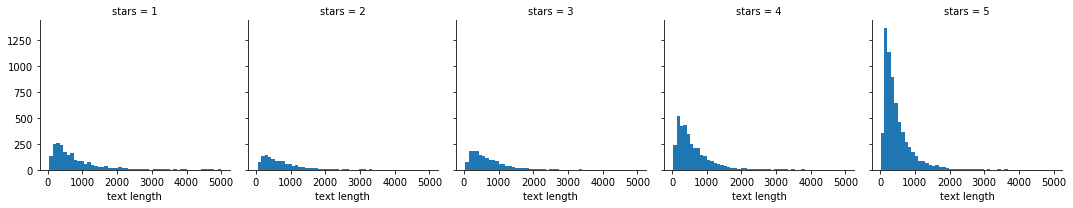

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt
g=sns.FacetGrid(data=reviews_df,col='stars')
g.map(plt.hist,'text length',bins=50)

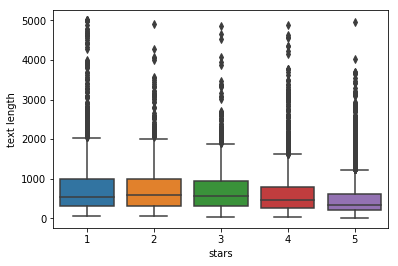

In [129]:
sns.boxplot(x='stars',y='text length',data=reviews_df)

In [130]:
stars=reviews_df.groupby('stars').mean()
stars.corr()

,cool,funny,useful,text length
cool,1.000000,-0.568517,-0.880963,-0.668907
funny,-0.568517,1.000000,0.755723,0.970777
useful,-0.880963,0.755723,1.000000,0.858904
text length,-0.668907,0.970777,0.858904,1.000000


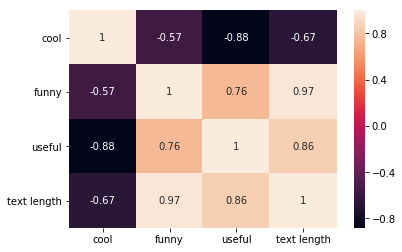

In [131]:
sns.heatmap(data=stars.corr(),annot=True)

In [132]:
reviews_1_5=reviews_df[(reviews_df['stars']==1)|(reviews_df['stars']==5)]
reviews_1_5.shape

(8630, 10)

In [133]:
x1=reviews_1_5['text']
y2=reviews_1_5['stars']

In [138]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/avinashreddy/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [139]:
import string
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]


In [155]:
from sklearn.feature_extraction.text import CountVectorizer

bow_transformer = CountVectorizer(analyzer=text_process).fit(x1)


In [156]:
x1 = bow_transformer.transform(x1)


In [157]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x1, y2, test_size=0.3, random_state=101)


In [158]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [159]:
preds = nb.predict(x_test)

In [160]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))


[[ 538   87]
 [  88 1876]]


             precision    recall  f1-score   support

          1       0.86      0.86      0.86       625
          5       0.96      0.96      0.96      1964

avg / total       0.93      0.93      0.93      2589



In [170]:
negative_review = reviews_1_5['text'][511094]
negative_review

"Wow!!!! We were so anxious to go Check it out. A few people playing pool wouldn't release their slot machines at the bar do we can sit drink eat and play. Really????????? I couldn't believe how the bartender didn't even step up and say something. I guess we are not even going to try it out. You just lost our business."

In [171]:
negative_review_transformed = bow_transformer.transform([negative_review])
nb.predict(negative_review_transformed)[0]


1

In [173]:
positive_review=reviews_1_5['text'][5448315]
positive_review

'Excellent service! Customer service was awesome. Driver was on time and very courteous. Transaction with military and discount code for Yelp review was quick and easy. Came within the hour and dropping out vehicle off to a mechanic. I gave him the name of the mechanic waiting at the shop for our car, and he wrote it on the paper to just verify. I would def use again and recommend this company. Fast, easy, efficient, no hassle, great attitude and great service. Highly recommended!'

In [174]:
positive_review_transformed = bow_transformer.transform([positive_review])
nb.predict(positive_review_transformed)[0]


5

In [186]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="/Users/avinashreddy/Desktop/215/best_weights2.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(20, input_dim=x1.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    #model.add(Dense(1, activation='softmax'))
    model.compile(loss="sparse_categorical_crossentropy", optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)


print('Training finished...Loading the best model')  
print()
model.load_weights("/Users/avinashreddy/Desktop/215/best_weights2.hdf5",) # load weights from best model



0
Train on 6041 samples, validate on 2589 samples
Epoch 1/100
 - 9s - loss: 1.5253 - val_loss: 1.9812
Epoch 2/100
 - 4s - loss: 1.8067 - val_loss: 1.5843
Epoch 3/100
 - 4s - loss: 1.5318 - val_loss: 1.7503
Epoch 4/100
 - 4s - loss: 1.5678 - val_loss: 1.6854
Epoch 5/100
 - 4s - loss: 1.4706 - val_loss: 1.7107
Epoch 6/100
 - 4s - loss: 1.4333 - val_loss: 1.6249
Epoch 7/100
 - 4s - loss: 1.3692 - val_loss: 1.6731
Epoch 00007: early stopping
1
Train on 6041 samples, validate on 2589 samples
Epoch 1/100
 - 9s - loss: 0.4854 - val_loss: 0.3953
Epoch 2/100
 - 4s - loss: 0.0793 - val_loss: 0.5044
Epoch 3/100
 - 4s - loss: 0.0182 - val_loss: 0.5432
Epoch 4/100
 - 4s - loss: 0.0095 - val_loss: 0.5712
Epoch 5/100
 - 4s - loss: 0.0036 - val_loss: 0.5570
Epoch 6/100
 - 4s - loss: 0.0010 - val_loss: 0.5814
Epoch 00006: early stopping
2
Train on 6041 samples, validate on 2589 samples
Epoch 1/100
 - 9s - loss: 0.8050 - val_loss: 1.1335
Epoch 2/100
 - 4s - loss: 0.9316 - val_loss: 0.8360
Epoch 3/100
 -